In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,shutil
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import layers
from keras import models
from keras.optimizers import Adam
from keras.applications import VGG16
from rectified_adam import RectifiedAdam

Using TensorFlow backend.


In [2]:
LR_function=ReduceLROnPlateau(monitor='val_acc',
                             patience=3,
                             verbose=1,
                             factor=0.5,
                             min_lr=0.000001)

In [3]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,                                   
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory('sample/train',
                                                  target_size=(224,224),
                                                  interpolation='bicubic',
                                                  class_mode='binary',
                                                  shuffle=True,
                                                  batch_size=64)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory('sample/valid',
                                                  target_size=(224,224),
                                                  interpolation='bicubic',
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  batch_size=64)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
results={}
OPTIMIZERS=[Adam(lr=1e-3) , RectifiedAdam(lr=1e-3)]

for optim in OPTIMIZERS:
    base_model=VGG16(input_shape=(224,224,3),include_top=False)
    base_model.trainable = False
 
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer=optim , loss='binary_crossentropy' , metrics=['accuracy'])
    model.fit_generator(train_batches,
                    steps_per_epoch = train_batches.samples / 64,
                    validation_data = valid_batches,
                    validation_steps = valid_batches.samples /64,
                    epochs = 100,
                    callbacks=[LR_function])
    
    train_acc=model.history.history['acc']
    train_loss=model.history.history['loss']
    val_acc=model.history.history['val_acc']
    val_loss=model.history.history['val_acc']
    
    exp_tag_name=f'exp-optimizer-{optim}'
    results[exp_tag_name] = {'train-acc':train_acc,
                          'train-loss':train_loss,
                          'val-acc':val_acc,
                          'val-loss':val_loss}    
    



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
32/31 [==============================] - 30s 949ms/step - loss: 2.0397 - acc: 0.8559 - val_loss: 1.3574 - val_acc: 0.9120
Epoch 2/100
32/31 [==============================] - 20s 633ms/step - loss: 2.4094 - acc: 0.8458 - val_loss: 1.3621 - va

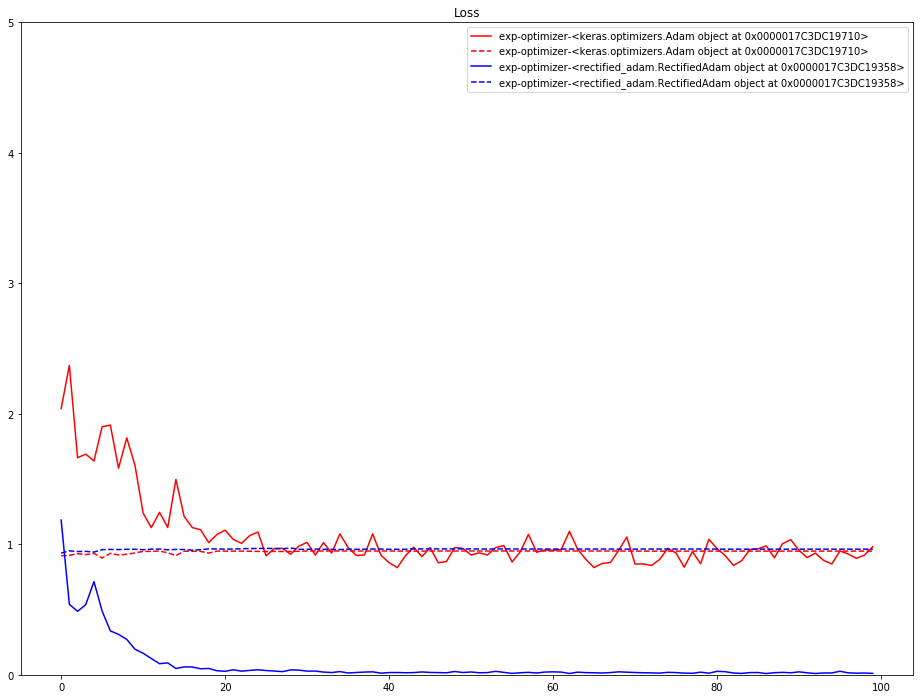

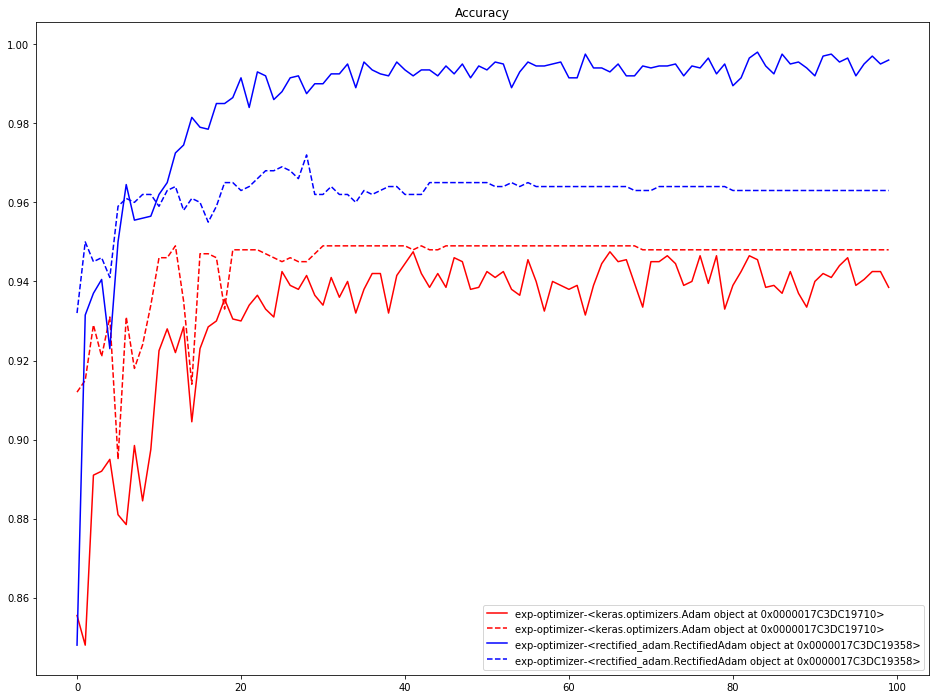

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "b"]

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['val-loss'])),results[cond]['val-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.savefig('./Loss.png')#儲存圖片
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['val-acc'])),results[cond]['val-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.savefig('./Accuracy.png')#儲存圖片
plt.show()